In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvtf
import torchvision.transforms.functional as TF

import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from datasets import PCam

/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_mean = (0.1307,)
data_stddev = (0.3081,)

transform_train = tvtf.Compose([
    tvtf.RandomRotation(degrees=(-180, 180)),  # random rotation
    tvtf.RandomHorizontalFlip(),  # random horizontal flip with a probability of 0.5
    tvtf.RandomVerticalFlip(),
    tvtf.ToTensor(),
    tvtf.Normalize(data_mean, data_stddev)
])
transform_test = tvtf.Compose(
    [
        tvtf.ToTensor(),
        tvtf.Normalize(data_mean, data_stddev),
    ]
)

train_set = PCam(root="data", train=True, download=True, transform=transform_train)
validation_set = PCam(root="data", train=False, valid=True, download=True, transform=transform_test)
test_set = PCam(root="data", train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)
val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

img_loader = torch.utils.data.DataLoader(  # single element for visualization purposes
    test_set,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)

len(train_loader), len(val_loader), len(test_loader)

(262144, 32768, 32768)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])


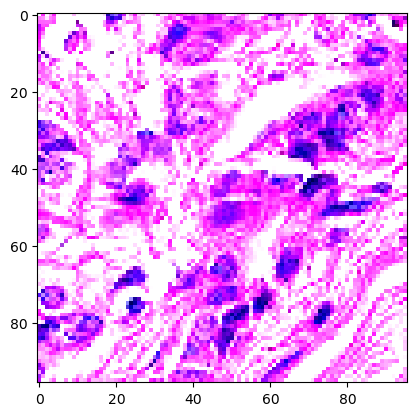

In [6]:
count = 0
for image, target in img_loader:
    print(target)
    plt.imshow(image.squeeze().transpose(0,2))
    plt.show()
    count += 1
    
    if count == 1: break

In [7]:
image.shape

torch.Size([1, 3, 96, 96])

In [ ]:
count = total = 0
for image, target in tqdm(img_loader):
    if target.item() == 0:
        count += 1
    total += 1
count / total  # dataset is balanced

In [ ]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(18432, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = TinyCNN()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for images, targets in train_loader:
    optimizer.zero_grad()
    out = model(images)
    loss = criterion(out, targets)
    loss.backward()
    print(loss.item())
    optimizer.step()

In [9]:
!pip install timm

  Using cached timm-0.9.16-py3-none-any.whl.metadata (38 kB)
Using cached timm-0.9.16-py3-none-any.whl (2.2 MB)


In [35]:
model = torch.hub.load('insitro/ChannelViT', 'camelyon_channelvit_small_p8_with_hcs_supervised', pretrained=True, map_location=torch.device('cpu'))
# https://github.com/insitro/ChannelViT

Using cache found in /home/wouter/.cache/torch/hub/insitro_ChannelViT_main


Warning!!!
Samplev2 channel vit randomly sample channels for each batch.
It is only compatible with Supervised learning
Doesn't work with DINO or Linear Prob


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [24]:
checkpoint = torch.load('modelptr.pth', map_location='cpu')  # https://github.com/helenqu/connect-later-wilds/tree/main


In [50]:
from urllib.request import urlopen
from PIL import Image
import torch.nn as nn
import timm

# load model from the hub
model = timm.create_model(
  model_name="hf-hub:1aurent/densenet161.tiatoolbox-pcam",
  pretrained=True,
).eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)



train_set = PCam(root="data", train=True, download=True, transform=transforms)
validation_set = PCam(root="data", train=False, valid=True, download=True, transform=transforms)
test_set = PCam(root="data", train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)
val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=16,
    shuffle=False,
    num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=False,
    num_workers=4,
)

img_loader = torch.utils.data.DataLoader(  # single element for visualization purposes
    test_set,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)